In [1]:
# Libraries
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.layers import Dense,Dropout,LSTM,Bidirectional,GRU
from keras.callbacks import EarlyStopping,Callback
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from pandas import DataFrame, read_csv,concat
from numpy import concatenate,reshape,array,amin,amax
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.optimizers import SGD
from statistics import mean
from keras import backend
from math import sqrt
from sys import argv
import datetime
import pickle
import talib
import docx
import time
import csv
import os

In [2]:
#Custom AutoStop
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_mape', value=1, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)        
            
        if epoch>5:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            if current < self.value:                
                self.model.stop_training = True

In [3]:
# Series to Supervised Learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    # print("I: ",i)
        cols.append(df.shift(i))
        # print("Column: ",cols)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        # print("COls: ",cols)
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # print("Names: ",names)

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [4]:
#Set Feature Combinations
def get_CurrentCombo(dataframe, combo_number):
    combinations = [[5,6,7,8,9], [3,4,5,6,7,8], [3,4,5,6,7,9], [3,4,5,6,9,8], [4,5,6],[3,4,5,6], [3,4,5,7,9,8], [3,4,7,6,9,8],[3,4,7,9,8],[4,7,9,8]]
    newDataFrame = dataframe.drop(dataframe.columns[combinations[combo_number]], axis = 1)
    return newDataFrame

In [5]:
# Read Data and Extract Values
fileName = 'BTC'  #write crypto name
dataframe = read_csv('final_datasets/'+fileName+'.csv', parse_dates=['time']) 
startIndex = 3  #start from 3rd column
nrows = dataframe.shape[0]

# Add features
sma = talib.SMA(dataframe['open '+fileName], timeperiod = 10)
ema = talib.EMA(dataframe['open '+fileName], timeperiod = 10)
macd = talib.MACD(dataframe['open '+fileName])[0]
rsi = talib.RSI(dataframe['open '+fileName])
mom = talib.MOM(dataframe['open '+fileName], timeperiod=15)

dataframe.insert(5,'sma',sma)
dataframe.insert(6,'ema',ema)
dataframe.insert(7,'macd',macd)
dataframe.insert(8,'rsi',rsi)
dataframe.insert(9,'mom',mom)

passDataframe = dataframe


In [6]:
combinationNumber = 4
dataframe = get_CurrentCombo(passDataframe, combinationNumber) #Max 9

In [7]:
dataset=dataframe.iloc[33:,:]
values = dataset.iloc[:,startIndex:].values #Getting values - Total Sentiment and BTC Values
valuesCrypto = dataset.iloc[:,-1:].values #Getting values -  C Values



num =dataset.loc[dataset['time'] == '2021-01-28'].index[0] #Testing data starts from this date
num2= dataset.iloc[[-1]].index[0]
num2+=1
percent=num/num2
percent
#percent=0.80 #Set a custom percentage of train data 
dataset

,time,sentiment_score,Tweet Volume,Weighted Sentiment,macd,rsi,mom,open BTC
33,2019-01-05 03:00:00,-0.163479,2741,-448.097236,20.205570,62.739256,-3.316667,3844.130000
34,2019-01-05 06:00:00,-0.162995,2991,-487.518000,20.770634,61.247191,4.493334,3838.196667
35,2019-01-05 09:00:00,-0.095735,3236,-309.798593,20.280502,59.023830,-14.210000,3829.470000
36,2019-01-05 12:00:00,-0.106470,3687,-392.555406,20.070886,59.936179,18.723333,3834.553333
37,2019-01-05 15:00:00,-0.104451,4370,-456.452976,19.395535,58.951791,51.146666,3831.013333
...,...,...,...,...,...,...,...,...
7413,2021-07-17 03:00:00,-0.010676,18590,-198.462543,-322.968509,36.585556,-1158.583330,31350.700000
7414,2021-07-17 06:00:00,-0.016053,19695,-316.161844,-315.488448,40.543735,-718.963330,31532.476670
7415,2021-07-17 09:00:00,-0.007262,20159,-146.389514,-305.349576,40.731416,-267.823330,31541.040000
7416,2021-07-17 12:00:00,-0.041026,26502,-1087.262508,-296.102964,40.294934,-162.906670,31513.753330


In [8]:
#Robust Scaler(MIX)
rb_tranformer = RobustScaler().fit(values)
rb_transformed=rb_tranformer.fit_transform(values)

rb_transformedCrypto=rb_tranformer.fit_transform(valuesCrypto)

#Quantile Transformer Scaler
# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# rb_transformed=qt.fit_transform(values)

# rb_tranformer_Crypto= QuantileTransformer(n_quantiles=10, random_state=0)
# rb_transformedCrypto=rb_tranformer_Crypto.fit_transform(valuesCrypto)

#Power Transformer
# pt = PowerTransformer()
# rb_transformed=pt.fit_transform(values)


# rb_tranformer_Crypto= PowerTransformer()
# rb_transformedCrypto=rb_tranformer_Crypto.fit_transform(valuesCrypto)

In [9]:
# MinMax Scaler
scaler = MinMaxScaler(feature_range = (0,1))
scaler = scaler.fit(rb_transformed)
scaled = scaler.fit_transform(rb_transformed)
scaled

array([[0.26953509, 0.51762497, 0.62512074, 0.56221302, 0.00796852],
       [0.26839652, 0.5177465 , 0.60871449, 0.56261151, 0.00787125],
       [0.27352949, 0.51764108, 0.58426713, 0.56165721, 0.00772818],
       ...,
       [0.27824914, 0.44760877, 0.38312968, 0.5487171 , 0.46203151],
       [0.25107443, 0.44959741, 0.37833026, 0.55407026, 0.46158417],
       [0.2835899 , 0.45521472, 0.42818265, 0.57734729, 0.46476958]])

In [10]:
print(amin(scaled),amax(scaled))

0.0 1.0


In [11]:
# Input and Output Sequence Length
input_sequence = 3
output_sequence = 1


# Call Series to Supervised Function
reframed = series_to_supervised(scaled, input_sequence, output_sequence)
reframed.to_csv('Results-5 features/'+fileName+'/'+'Trial'+'_Reframed', index= False)

#Store Column Names for Documentation
Colname= dataframe.columns[3:-1]
Colname = '-'.join(Colname)
Colname

'Weighted Sentiment-macd-rsi-mom'

In [12]:
# Drop current sentiment/any other feature that might be added in the future(at time t)
dropColumns = []
for i in range(values.shape[1]-1):
    dropColumns.append('var{}(t)'.format(i+1))
    
# for i in range(values.shape[1]):
#     dropColumns.append('var{}(t-1)'.format(i+1))
# for i in range(3,8):
#     for j in range(1,values.shape[1]+1):
#         dropColumns.append('var{}(t-{})'.format(j,i))
# print(dropColumns)
reframed=reframed.drop(columns=dropColumns)

# Ignore the headers
reframedValues = reframed.values
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
3,0.269535,0.517625,0.625121,0.562213,0.007969,0.268397,0.517746,0.608714,0.562612,0.007871,0.273529,0.517641,0.584267,0.561657,0.007728,0.007812
4,0.268397,0.517746,0.608714,0.562612,0.007871,0.273529,0.517641,0.584267,0.561657,0.007728,0.271139,0.517596,0.594299,0.563338,0.007812,0.007753
5,0.273529,0.517641,0.584267,0.561657,0.007728,0.271139,0.517596,0.594299,0.563338,0.007812,0.269294,0.517451,0.583475,0.564992,0.007753,0.007922
6,0.271139,0.517596,0.594299,0.563338,0.007812,0.269294,0.517451,0.583475,0.564992,0.007753,0.268791,0.517466,0.605573,0.564660,0.007922,0.007693
7,0.269294,0.517451,0.583475,0.564992,0.007753,0.268791,0.517466,0.605573,0.564660,0.007922,0.272546,0.517191,0.560820,0.564875,0.007693,0.007218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,0.244129,0.446917,0.436024,0.516696,0.469274,0.236618,0.448747,0.391838,0.504433,0.464928,0.251381,0.446757,0.355331,0.500382,0.460952,0.458911
7381,0.236618,0.448747,0.391838,0.504433,0.464928,0.251381,0.446757,0.355331,0.500382,0.460952,0.276745,0.443820,0.337543,0.503268,0.458911,0.461891
7382,0.251381,0.446757,0.355331,0.500382,0.460952,0.276745,0.443820,0.337543,0.503268,0.458911,0.273346,0.445428,0.381066,0.525699,0.461891,0.462032
7383,0.276745,0.443820,0.337543,0.503268,0.458911,0.273346,0.445428,0.381066,0.525699,0.461891,0.278249,0.447609,0.383130,0.548717,0.462032,0.461584


In [13]:
#Splitting data into train and test sets

n_train_days = int(percent*nrows)
train = reframedValues[:n_train_days, :]
test = reframedValues[n_train_days:nrows, :]
# valuesCrypto = reframed.iloc[:,-1:].values #Getting values -  C Values

#Assigning inputs and output datasets
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# print(train_X.shape)

#Reshaping input to be 3 dimensions (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], input_sequence, train_X.shape[1]//input_sequence))
test_X = test_X.reshape((test_X.shape[0], input_sequence, test_X.shape[1]//input_sequence))
print(train_X[0])

[[0.26953509 0.51762497 0.62512074 0.56221302 0.00796852]
 [0.26839652 0.5177465  0.60871449 0.56261151 0.00787125]
 [0.27352949 0.51764108 0.58426713 0.56165721 0.00772818]]


In [14]:
##### Build LSTM Neural Network model
neurons = 50
dropout = 0.0
epochs = 100
batch_size = 64
stop_val=1.2
backend.clear_session()
model = Sequential()
model.add(Bidirectional(GRU(neurons, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(LSTM(neurons,activation ='tanh')) 
model.add(Dropout(dropout))
model.add(Dense(1))
backend.set_epsilon(1)
model.compile(optimizer='adam', loss='mse',metrics=['mape'])

# Uncomment below line to get summary of the model
# print(model.summary(line_length=None, positions=None, print_fn=None))

callbacks = [EarlyStoppingByLossVal(monitor='val_mape', value=stop_val, verbose=2)]

#Fitting model
history = model.fit(train_X, train_y, epochs =epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/100
95/95 - 1s - loss: 0.0015 - mape: 2.6260 - val_loss: 0.0234 - val_mape: 12.9423
Epoch 2/100
95/95 - 0s - loss: 0.0205 - mape: 9.0865 - val_loss: 0.1754 - val_mape: 39.7962
Epoch 3/100
95/95 - 0s - loss: 0.0076 - mape: 5.6862 - val_loss: 0.0320 - val_mape: 15.2718
Epoch 4/100
95/95 - 0s - loss: 0.0074 - mape: 5.4843 - val_loss: 0.0112 - val_mape: 8.5476
Epoch 5/100
95/95 - 0s - loss: 0.0043 - mape: 4.3901 - val_loss: 0.0022 - val_mape: 3.6531
Epoch 6/100
95/95 - 0s - loss: 0.0017 - mape: 2.4086 - val_loss: 0.0011 - val_mape: 2.5113
Epoch 7/100
Epoch 00006: early stopping THR
95/95 - 0s - loss: 1.2227e-04 - mape: 0.8252 - val_loss: 9.1967e-04 - val_mape: 2.2711
Epoch 8/100
Epoch 00007: early stopping THR
95/95 - 0s - loss: 1.2318e-04 - mape: 0.8252 - val_loss: 8.6883e-04 - val_mape: 2.2263
Epoch 9/100
Epoch 00008: early stopping THR
95/95 - 0s - loss: 1.0577e-04 - mape: 0.7726 - val_loss: 6.1969e-04 - val_mape: 1.8644
Epoch 10/100
Epoch 00009: early stopping THR
95/95 - 0s - 

In [15]:
# Predicition
model_prediction = model.predict(test_X)

# Inverse Scale

scalerCrypto = MinMaxScaler(feature_range = (0,1))
scalerCrypto = scalerCrypto.fit(rb_transformedCrypto)
scaledCrypto = scalerCrypto.inverse_transform(model_prediction)

rb_tranformer_Crypto = RobustScaler().fit(valuesCrypto)
rb_transformedCrypto=rb_tranformer_Crypto.fit_transform(valuesCrypto)
unscaled_Crypto = rb_tranformer_Crypto.inverse_transform(scaledCrypto)

# rb_tranformer_Crypto=QuantileTransformer(n_quantiles=10, random_state=0)
# rb_transformed_Crypto_unscaled = rb_tranformer_Crypto.inverse_transform(unscaled_Crypto)

# scalerCryptoPower = PowerTransformer()
# scalerCryptoPower = scalerCryptoPower.fit(valuesCrypto)
# unscaled_Crypto = scalerCryptoPower.inverse_transform(unscaled_Crypto)

unscaled_Crypto

array([[34071.75 ],
       [34144.742],
       [33885.137],
       ...,
       [31254.547],
       [31328.92 ],
       [31314.014]], dtype=float32)

In [16]:
# model_prediction_unscale = transformerCrypto.inverse_transform(model_minmax_unscale)

model_prediction_unscale = unscaled_Crypto

predictedValues = reshape(model_prediction_unscale, model_prediction_unscale.shape[0])

actualValues = valuesCrypto[n_train_days+input_sequence:] #test_y+input_sequence:

actualValues = reshape(actualValues, actualValues.shape[0])
actualValues

array([33876.51667, 33376.76667, 33865.13333, ..., 31541.04   ,
       31513.75333, 31708.05667])

In [17]:
test_X

array([[[0.23259957, 0.49884081, 0.49255991, 0.55316834, 0.49601369],
        [0.24960054, 0.50424645, 0.50225051, 0.53963194, 0.49782069],
        [0.2568353 , 0.5193654 , 0.5549062 , 0.58498866, 0.50812246]],

       [[0.24960054, 0.50424645, 0.50225051, 0.53963194, 0.49782069],
        [0.2568353 , 0.5193654 , 0.5549062 , 0.58498866, 0.50812246],
        [0.25186501, 0.52297535, 0.50866123, 0.54753166, 0.5003193 ]],

       [[0.2568353 , 0.5193654 , 0.5549062 , 0.58498866, 0.50812246],
        [0.25186501, 0.52297535, 0.50866123, 0.54753166, 0.5003193 ],
        [0.24073885, 0.51711928, 0.46403944, 0.51485994, 0.4921264 ]],

       ...,

       [[0.25138098, 0.44675703, 0.35533056, 0.50038199, 0.46095235],
        [0.27674515, 0.44381952, 0.33754315, 0.50326785, 0.45891108],
        [0.2733457 , 0.44542823, 0.381066  , 0.52569858, 0.46189112]],

       [[0.27674515, 0.44381952, 0.33754315, 0.50326785, 0.45891108],
        [0.2733457 , 0.44542823, 0.381066  , 0.52569858, 0.46189112],

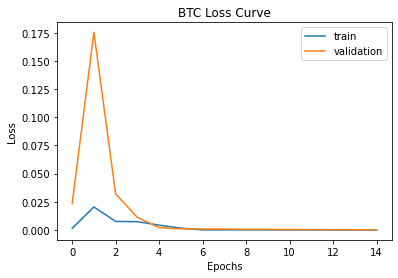

In [18]:
#Plotting training loss vs validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title(fileName+' Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LossCurves/'+fileName+'/'+fileName+"-"+Colname+'.png', dpi=700)
plt.show()

In [19]:
#Uncomment to make directories

# assets_filename = os.listdir('./final_datasets')
# assets_filename
# assets = [x.split('.')[0] for x in assets_filename]
# for asset in assets:    
#     os.mkdir('Trend_Graphs/'+asset)

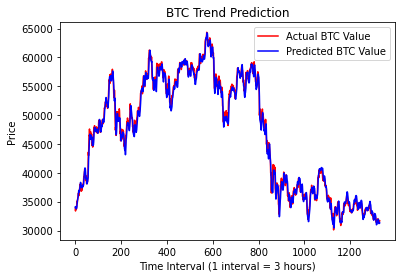

In [20]:
#Visualising Results (Actual vs Predicted)
plt.plot(actualValues, color = 'red', label = 'Actual '+ fileName + ' Value')
plt.plot(predictedValues, color = 'blue', label = 'Predicted '+ fileName + ' Value') #[1:38]
plt.title(fileName+' Trend Prediction')
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()

# Uncomment below line to save the figure
plt.savefig('Trend_Graphs/'+fileName+'/'+fileName+"-"+Colname+'.png', dpi=700)

plt.show()

In [21]:
actual= DataFrame(actualValues, columns= ['Actual Value'])
predicted=DataFrame(predictedValues, columns= ['Predicted Value'])

#Calculating RMSE and MAE
errorDF=concat([actual,predicted], axis=1)
errorDF.dropna(inplace=True)
rmse = sqrt(mean_squared_error(errorDF.iloc[:,0], errorDF.iloc[:,1]))
mae = mean_absolute_error(errorDF.iloc[:,0], errorDF.iloc[:,1])
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Test MAE: 683.507
Test RMSE: 897.442


In [22]:
#saving model 
model_json = model.to_json()
with open('models/'+fileName+'/'+fileName+"_"+Colname+"_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('models/'+fileName+'/'+fileName+"_"+Colname+"_model.h5")
print("Saved " + fileName+"_"+Colname+"_model.h5 to disk")

Saved BTC_Weighted Sentiment-macd-rsi-mom_model.h5 to disk


In [23]:
# Write to csv
writeFileName = "-"+Colname+"-Results.csv"
timestamp = DataFrame(dataset['time'][n_train_days+input_sequence:], columns= ['time'])
timestamp.reset_index(drop=True, inplace=True)
results=concat([timestamp,actual,predicted], axis=1)
print("Head: ",results.head())
# print("Tail: ",results.tail())
print(results.iloc[-15:,:])
results.dropna(inplace=True)
results.to_csv('Results-5 features/'+fileName+'/'+fileName+writeFileName, index= False)

Head:                   time  Actual Value  Predicted Value
0 2021-02-01 12:00:00   33876.51667     34071.750000
1 2021-02-01 15:00:00   33376.76667     34144.742188
2 2021-02-01 18:00:00   33865.13333     33885.136719
3 2021-02-01 21:00:00   33684.12667     33809.125000
4 2021-02-02 00:00:00   33691.25333     33764.703125
                    time  Actual Value  Predicted Value
1315 2021-07-15 21:00:00   31732.31000     30989.962891
1316 2021-07-16 00:00:00   31776.24667     31038.023438
1317 2021-07-16 03:00:00   31915.34333     31129.189453
1318 2021-07-16 06:00:00   31736.73000     31397.744141
1319 2021-07-16 09:00:00   31399.84667     31460.853516
1320 2021-07-16 12:00:00   31523.06333     31408.244141
1321 2021-07-16 15:00:00   32033.70667     31406.810547
1322 2021-07-16 18:00:00   31982.83000     31816.603516
1323 2021-07-16 21:00:00   31717.69667     31959.837891
1324 2021-07-17 00:00:00   31475.21333     31826.843750
1325 2021-07-17 03:00:00   31350.70000     31434.156250
132

In [24]:
# Analyzer 2
result_value=[]

for n_percent in range(3):
    #n_percent = iteration/10.0
    with open('Results-5 features/'+fileName+'/'+fileName+writeFileName, newline='') as read_file:

        results = csv.reader(read_file, delimiter=',', quotechar='|')
        next(results)

        time = []
        actual = []
        predicted = []

        # Pull data from CSV and store in arrays.
        for row in results:
            # print(row)
            time.append(row[0])
            actual.append(float(row[1]))
            predicted.append(float(row[2]))

        actual_delta = []
        predicted_delta = []
        correct_long = 0
        incorrect_long = 0
        correct_short = 0
        incorrect_short = 0

        profit = []
        profit_agg = 0
        
        # Process predictions, print analytics.
        for i in range(2, len(actual) - 4):
            a_delta = (actual[i + 1] - actual[i]) / actual[i + 1]
#             p_delta = (predicted[i + 1] - predicted[i]) / predicted[i + 1]
            #Uncomment below and comment above to see shifted values
            p_delta = (predicted[i + 1] - predicted[i]) / predicted[i + 1]
    #         print("time_start", time[i])
    #         print("time_ended", time[i+1])
    #         print("actual_price", actual[i], "->", actual[i+1])
    #         print("actual_delta", a_delta * 100)
    #         print("predicted_price", predicted[i], "->", predicted[i + 1])
    #         print("predicted_delta", p_delta * 100)
    #         print("difference", abs(a_delta - p_delta) * 100)

            if p_delta > 0 and a_delta > 0 and abs(p_delta)*100>n_percent:
                correct_long += 1
                profits = 10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            if p_delta > 0 > a_delta and abs(p_delta)*100>n_percent:
                incorrect_long += 1
                profits = -10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            # To ignore the "short" predictions, comment out the following 2 if-blocks.

            if p_delta < 0 and a_delta < 0 and abs(p_delta)*100>n_percent:
                correct_short += 1
                profits = 10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)

            if p_delta < 0 < a_delta and abs(p_delta)*100>n_percent:
                incorrect_short += 1
                profits = -10000 * abs(a_delta)
                profit.append(profits)
                profit_agg += profits
                #print('gain/loss', profits)
            

    #         print()
        long_p=correct_long/(correct_long+incorrect_short)*100
        short_p=correct_short/(correct_short+incorrect_long)*100
        total_correct= (correct_long+correct_short)/(correct_long+incorrect_long+correct_short+incorrect_short)*100
        print('Analyzer 2 - Percent: ',n_percent)
        print("------------")
        print('LONG VALUES')
#       print('')
        print('correct_long', correct_long)
        print('incorrect_short', incorrect_short)
        print('correct_long_percentage', round(long_p,2))
        print('')
        print('SHORT VALUES')
#       print('')
        print('correct_short', correct_short)
        print('incorrect_long', incorrect_long)
        print('correct_short_percentage', round(short_p,2))
        print('')
        print('TOTAL')
        print('total_correct',correct_short+correct_long)
        print('total_incorrect',incorrect_long+incorrect_short )
        print('correct_total_percentage', round(total_correct,2))
        print('profit_tracker', round(profit_agg,2))
        print()
        print('########################################################')
        print()
        
        st='LONG VALUES\n\ncorrect_long: {}\nincorrect_short: {}\ncorrect_long_percentage: {}\n\nSHORT VALUES\n\ncorrect_short: {}\nincorrect_long: {}\ncorrect_short_percentage: {}\n\nTOTAL\n\ntotal_correct: {}\ntotal_incorrect: {}\ncorrect_total_percentage: {}\nprofit_tracker: {}'.format(correct_long,incorrect_short,long_p,correct_short,incorrect_long,short_p,correct_short+correct_long,incorrect_long+incorrect_short,total_correct,profit_agg)
        result_value.append(st)

Analyzer 2 - Percent:  0
------------
LONG VALUES
correct_long 372
incorrect_short 310
correct_long_percentage 54.55

SHORT VALUES
correct_short 335
incorrect_long 307
correct_short_percentage 52.18

TOTAL
total_correct 707
total_incorrect 617
correct_total_percentage 53.4
profit_tracker 19472.29

########################################################

Analyzer 2 - Percent:  1
------------
LONG VALUES
correct_long 123
incorrect_short 84
correct_long_percentage 59.42

SHORT VALUES
correct_short 120
incorrect_long 80
correct_short_percentage 60.0

TOTAL
total_correct 243
total_incorrect 164
correct_total_percentage 59.71
profit_tracker 16540.77

########################################################

Analyzer 2 - Percent:  2
------------
LONG VALUES
correct_long 23
incorrect_short 22
correct_long_percentage 51.11

SHORT VALUES
correct_short 34
incorrect_long 23
correct_short_percentage 59.65

TOTAL
total_correct 57
total_incorrect 45
correct_total_percentage 55.88
profit_tracker 2265

In [ ]:

# #Generate Document for Hyperparameters
# try:
#     doc = docx.Document('CONFIG_extended.docx')
# except:
#     doc = docx.Document()
    
# name=doc.add_paragraph()
# bold= name.add_run('\n\n'+fileName+'-'+Colname)
# bold.bold=True

# records = [epochs, batch_size, neurons, dropout,stop_val]

# menuTable = doc.add_table(rows=1,cols=5)
# menuTable.style= 'Table Grid'
# hdr_Cells = menuTable.rows[0].cells
# hdr_Cells[0].text = 'Epoch'
# hdr_Cells[1].text = 'Batch Size'
# hdr_Cells[2].text = 'Neurons'
# hdr_Cells[3].text = 'Dropout'
# hdr_Cells[4].text = 'stop_val'
# row_Cells = menuTable.add_row().cells
# for i, item in enumerate(records):
#     row_Cells[i].text = str(item)

# # doc.add_page_break()
# doc.save('CONFIG_extended.docx')
# #os.system("CONFIG.docx")

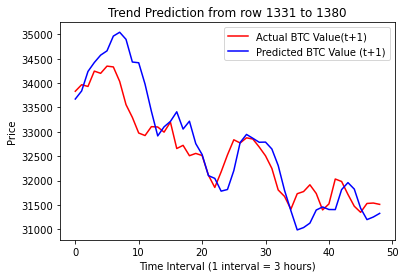

In [25]:
frm=-50
to=-1

plt.plot(actualValues[frm:to], color = 'red', label = 'Actual BTC Value(t+1)')
plt.plot(predictedValues[frm:to], color = 'blue', label = 'Predicted BTC Value (t+1)') 
plt.title('Trend Prediction from row '+str(len(actualValues)-to)+' to '+str(len(actualValues)-frm))
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()


# plt.plot(actualValues[1:100], color = 'red', label = 'Actual'+ fileName + ' Value')
# plt.plot(predictedValues[1:100], color = 'blue', label = 'Predicted '+ fileName + ' Value') #[1:38]
# plt.title(fileName+' Trend Prediction')
# plt.xlabel('Time Interval (1 interval = 3 hour)')
# plt.ylabel('Price')
# plt.legend()

plt.show()

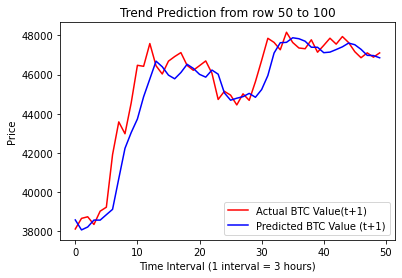

In [26]:
frm=50
to=100
plt.plot(actualValues[frm:to], color = 'red', label = 'Actual BTC Value(t+1)')
plt.plot(predictedValues[frm:to], color = 'blue', label = 'Predicted BTC Value (t+1)') #[1:38]
plt.title('Trend Prediction from row '+str(frm)+' to '+str(to))
plt.xlabel('Time Interval (1 interval = 3 hours)')
plt.ylabel('Price')
plt.legend()